# Regresion Polinomial & Feature engineering

Importando paquetes

In [216]:
import tensorflow as tf
import time
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns

Cargando archivo csv

In [217]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [218]:
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

## Correalciones

Encontrando correlaciones entre las variables y la variables quality.

In [219]:
correlations = data.corr()['quality'].drop('quality')
print(correlations)

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
Name: quality, dtype: float64


## Mapa de correlaciones

La mejor correlacion la tienen los valers 'Volatile Acidity' y 'Alcohol'. La unica diferencia es que una es correlacion negativa (si una aumenta la otra decrece) y la otra es una correlacion positiva (si una aumenta, la otra tambien aumenta).

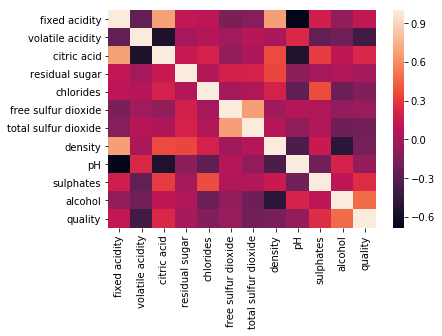

In [220]:
sns.heatmap(data.corr())
plt.show()

## Funcion para obtener mejores features.

In [221]:
def get_features(correlation_threshold):
    abs_corrs = correlations.abs()
    high_correlations = abs_corrs
    return correlations[abs_corrs > correlation_threshold].index.values.tolist()

In [222]:
# taking features with correlation more than 0.05 as input x and quality as target variable y 
features = get_features(0.35) 
print(features) 
x = data[features] 
y = data['quality']

['volatile acidity', 'alcohol']


## Particion de la data: train y test

Los features seleccionados fueron los anteriores.

In [223]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


### Grafica 'Volatile acidity' vs 'Quality'

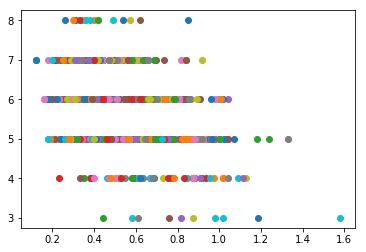

In [224]:
plt.plot(np.array([data['volatile acidity']]),np.array([data['quality']]), 'o')
plt.show()

### Grafica 'Alcohol' vs 'Quality'

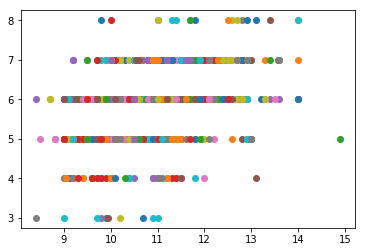

In [225]:
plt.plot(np.array([data['alcohol']]),np.array([data['quality']]), 'o')
plt.show()

### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

## Creacion de variables

In [205]:
a = np.array(X_train['volatile acidity'])
b = np.array(X_train['alcohol'])
a2 = np.array(a*a)
b2 = np.array(b*b)
ab = np.array(a*b)
ones = np.linspace(1, 1, num=X_train.shape[0])
mat = np.array([ones, a, b, a2, b2, ab])
mat = mat.transpose()


## Definiendo grafo

In [206]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    X = tf.placeholder("float",name="X") 
    Y = tf.placeholder("float",name="Y") 
    
    lr = tf.placeholder("float")
    
    W = tf.Variable(np.zeros((6,1)), name = "W", dtype="float")
        
    with tf.name_scope("hipotesis"):
        y_pred = tf.matmul(X, W,name="hipotesis")

    with tf.name_scope("funcion_costo"):
        cost = tf.reduce_mean(tf.pow(y_pred-Y, 2)) / (2)
        
    with tf.name_scope("Gradient_Descent"):
        cost_summary = tf.summary.scalar("cost",cost)
        
    optimizador = tf.train.GradientDescentOptimizer(lr).minimize(cost)
    init = tf.global_variables_initializer()

## Funcion de modelo: Regresion Polinomial

In [207]:

def train(epochs = 200, learning_rate = 0.1, step=10):
    tf.reset_default_graph()

    start = time.time()
    with tf.Session(graph=g) as sess: 
        writer = tf.summary.FileWriter('./graphs/lr='+str(learning_rate), sess.graph)
        sess.run(init) 
        
        for epoch in range(epochs): 

            _,c = sess.run([optimizador,cost_summary], feed_dict = {X : mat, Y : y, lr: learning_rate}) 
            writer.add_summary(c, epoch+1)

            if (epoch + 1) % step == 0:
                co,we= sess.run([cost,W],feed_dict = {X : mat, Y : y, lr: learning_rate}) 
                print("Epoch", (epoch + 1), ": cost =", co, "W =", we) 
                
        writer.close()
    end = time.time()
    
    print("Total time ",end-start)

### Training with  learning_rate equals to 0.00001

In [208]:
train(learning_rate = 0.00001)

Epoch 10 : cost = 1.988398 W = [[0.00033868]
 [0.00017938]
 [0.00348264]
 [0.00010574]
 [0.03613982]
 [0.00183338]]
Epoch 20 : cost = 1.0641522 W = [[0.00044284]
 [0.00023751]
 [0.00446615]
 [0.00014113]
 [0.04533891]
 [0.00238521]]
Epoch 30 : cost = 1.003811 W = [[0.00048722]
 [0.00026472]
 [0.0048126 ]
 [0.00015858]
 [0.04767067]
 [0.00261032]]
Epoch 40 : cost = 0.9996041 W = [[0.00051636]
 [0.00028404]
 [0.00499665]
 [0.00017145]
 [0.04825193]
 [0.0027521 ]]
Epoch 50 : cost = 0.9990446 W = [[0.0005416 ]
 [0.00030135]
 [0.00513927]
 [0.00018315]
 [0.04838696]
 [0.00287258]]
Epoch 60 : cost = 0.9987226 W = [[0.00056585]
 [0.00031813]
 [0.00527131]
 [0.00019454]
 [0.04840827]
 [0.00298759]]
Epoch 70 : cost = 0.99841565 W = [[0.00058985]
 [0.00033478]
 [0.00540063]
 [0.00020585]
 [0.04840058]
 [0.00310116]]
Epoch 80 : cost = 0.9981095 W = [[0.00061377]
 [0.00035139]
 [0.00552924]
 [0.00021714]
 [0.04838552]
 [0.00321431]]
Epoch 90 : cost = 0.9978052 W = [[0.00063767]
 [0.00036799]
 [0.0

![](lr0p00001.png)

### Training with  learning_rate equals to 0.0001

In [209]:
train(learning_rate = 0.0001)

Epoch 10 : cost = 0.99749917 W = [[0.00066159]
 [0.0003846 ]
 [0.00578609]
 [0.00023971]
 [0.04835105]
 [0.0034405 ]]
Epoch 20 : cost = 0.99446255 W = [[0.00090022]
 [0.00055005]
 [0.00706777]
 [0.000352  ]
 [0.04817563]
 [0.00456616]]
Epoch 30 : cost = 0.9914492 W = [[0.00113831]
 [0.00071475]
 [0.00834653]
 [0.0004636 ]
 [0.04800067]
 [0.0056853 ]]
Epoch 40 : cost = 0.9884577 W = [[0.00137586]
 [0.0008787 ]
 [0.0096224 ]
 [0.0005745 ]
 [0.0478263 ]
 [0.00679795]]
Epoch 50 : cost = 0.98548836 W = [[0.00161287]
 [0.00104191]
 [0.01089539]
 [0.00068471]
 [0.04765251]
 [0.00790414]]
Epoch 60 : cost = 0.98254246 W = [[0.00184934]
 [0.00120437]
 [0.0121655 ]
 [0.00079423]
 [0.0474793 ]
 [0.00900391]]
Epoch 70 : cost = 0.9796176 W = [[0.00208529]
 [0.00136611]
 [0.01343275]
 [0.00090307]
 [0.04730668]
 [0.01009729]]
Epoch 80 : cost = 0.97671515 W = [[0.0023207 ]
 [0.00152711]
 [0.01469715]
 [0.00101123]
 [0.04713462]
 [0.0111843 ]]
Epoch 90 : cost = 0.97383446 W = [[0.00255559]
 [0.00168738

![](lr0p0001.png)

### Training with  learning_rate equals to 0.001

In [210]:
train(learning_rate = 0.001)

Epoch 10 : cost = 3.9971023e+22 W = [[-2.1656072e+07]
 [-1.1197036e+07]
 [-2.3078104e+08]
 [-6.4963725e+06]
 [-2.4878684e+09]
 [-1.1833986e+08]]
Epoch 20 : cost = inf W = [[-1.1102519e+18]
 [-5.7404430e+17]
 [-1.1831575e+19]
 [-3.3305290e+17]
 [-1.2754690e+20]
 [-6.0669897e+18]]
Epoch 30 : cost = inf W = [[-5.6919878e+28]
 [-2.9429821e+28]
 [-6.0657509e+29]
 [-1.7074790e+28]
 [-6.5390054e+30]
 [-3.1103948e+29]]
Epoch 40 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 50 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 60 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 70 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 80 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 90 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 100 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 110 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 120 : cost = nan W = [[na

![](lr0p001.png)

### Training with  learning_rate equals to 0.01

In [211]:
train(learning_rate = 0.01)

Epoch 10 : cost = inf W = [[-4.52306511e+17]
 [-2.33860179e+17]
 [-4.82007701e+18]
 [-1.35682716e+17]
 [-5.19614066e+19]
 [-2.47163479e+18]]
Epoch 20 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 30 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 40 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 50 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 60 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 70 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 80 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 90 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 100 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 110 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 120 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 130 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 140 : cost = nan W = 

![](lr0p01.png)

### Training with  learning_rate equals to 0.1

In [212]:
train(learning_rate = 0.1)

Epoch 10 : cost = inf W = [[-4.8546698e+27]
 [-2.5100555e+27]
 [-5.1734554e+28]
 [-1.4563015e+27]
 [-5.5770895e+29]
 [-2.6528418e+28]]
Epoch 20 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 30 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 40 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 50 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 60 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 70 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 80 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 90 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 100 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 110 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 120 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 130 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 140 : cost = nan W = [[nan]

![](lr0p1.png)

### Training with  learning_rate equals to 1

In [213]:
train(learning_rate = 1)

Epoch 10 : cost = inf W = [[-4.8890150e+37]
 [-2.5278124e+37]
 [          -inf]
 [-1.4666046e+37]
 [          -inf]
 [-2.6716097e+38]]
Epoch 20 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 30 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 40 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 50 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 60 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 70 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 80 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 90 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 100 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 110 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 120 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 130 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 140 : cost = nan W = [[nan]

![](lr1.png)

### Training with  learning_rate equals to 10

In [214]:
train(learning_rate = 10)

Epoch 10 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 20 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 30 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 40 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 50 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 60 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 70 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 80 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 90 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 100 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 110 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 120 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 130 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 140 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 150 : cost = nan W = [[

![](lr10.png)

## Grafo

![](Grafo.png)